# Deploy Falcon 180B on Amazon SageMaker

Falcon 180B is the newest version of [Falcon LLM family](https://huggingface.co/blog/falcon). It is the biggest open source model with 180B parameter and trained on more data - 3.5T tokens with context length window upto 4K tokens. Falcon 180B is created by the [Technology Innovation Institute in Abu Dhabi](https://www.tii.ae/), and released under the Apache 2.0 license. Falcon 180B is the most powerful open source LLM today and competes with Googles PaLM-2 Large and is better than OpenAIs GPT-3.5. 

In this blog you will learn how to deploy Falcon 180B to Amazon SageMaker. We are going to use the Hugging Face LLM DLC is a new purpose-built Inference Container to easily deploy LLMs in a secure and managed environment. The DLC is powered by [Text Generation Inference (TGI)](https://github.com/huggingface/text-generation-inference) a scalelable, optimized solution for deploying and serving Large Language Models (LLMs). The Blog post also includes Hardware requirements for the different model sizes. 

In the blog will cover how to:
1. [Setup development environment](#1-setup-development-environment)
2. [Retrieve the new Hugging Face LLM DLC](#2-retrieve-the-new-hugging-face-llm-dlc)
3. [Hardware requirements](#3-hardware-requirements)
4. [Deploy Falcon 180B to Amazon SageMaker](#4-deploy-llama-2-to-amazon-sagemaker)
5. [Run inference and chat with the model](#5-run-inference-and-chat-with-the-model)
6. [Create Gradio Chatbot Demo](#6-create-gradio-chatbot-demo)

Lets get started!


## 1. Setup development environment

We are going to use the `sagemaker` python SDK to deploy Falcon 180B to Amazon SageMaker. We need to make sure to have an AWS account configured and the `sagemaker` python SDK installed. 

In [ ]:
!pip install "sagemaker>=2.175.0" --upgrade --quiet

If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it.


In [1]:
import sagemaker
import boto3

boto3_session=boto3.session.Session(region_name="us-west-2")
sess = sagemaker.Session(boto3_session)

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

print(f"sagemaker role arn: {role}")
print(f"sagemaker session region: {sess.boto_region_name}")


Couldn't call 'get_role' to get Role ARN from role name philippschmid to get Role path.


sagemaker role arn: arn:aws:iam::558105141721:role/sagemaker_execution_role
sagemaker session region: us-west-2


## 2. Retrieve the new Hugging Face LLM DLC

Compared to deploying regular Hugging Face models we first need to retrieve the container uri and provide it to our `HuggingFaceModel` model class with a `image_uri` pointing to the image. To retrieve the new Hugging Face LLM DLC in Amazon SageMaker, we can use the `get_huggingface_llm_image_uri` method provided by the `sagemaker` SDK. This method allows us to retrieve the URI for the desired Hugging Face LLM DLC based on the specified `backend`, `session`, `region`, and `version`. You can find the available versions [here](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#huggingface-text-generation-inference-containers)


In [2]:
from sagemaker.huggingface import get_huggingface_llm_image_uri

# retrieve the llm image uri
llm_image = get_huggingface_llm_image_uri(
  "huggingface",
  version="0.9.3",
  session=sess,
)

# print ecr image uri
print(f"llm image uri: {llm_image}")

llm image uri: 763104351884.dkr.ecr.us-west-2.amazonaws.com/huggingface-pytorch-tgi-inference:2.0.1-tgi0.9.3-gpu-py39-cu118-ubuntu20.04


## 3. Hardware requirements

Falcon 180B is the biggst version of the Falcon family running it requires powerful hardware. Below is a set up minimum requirements. We plan to run more test, e.g. `gptq` in the coming weeks, but it is to assume that you need atleast `p4d` instances to run Falcon 180B. 


| Model        | Instance Type     | Quantization | Tested | 
|--------------|-------------------|--------------|-----------------------|
| [Falcon 180B]() | `(ml.)p4de.24xlarge` | `-`          | ✅                     | 
| [Falcon 180B]() | `(ml.)p4d.24xlarge` | `gptq`          | 🛑                     | 
| [Falcon 180B]() | `(ml.)p5.48xlarge` | `-`          | 🛑                     | 


## 4. Deploy Falcon 180B to Amazon SageMaker

To deploy [hf-extreme-scale/falcon-180B-chat](https://huggingface.co/hf-extreme-scale/falcon-180B-chat) to Amazon SageMaker we create a `HuggingFaceModel` model class and define our endpoint configuration including the `hf_model_id`, `instance_type` etc. We will use a `p4de.24xlarge` instance type, which has 8 NVIDIA A100 GPUs and 480GB of GPU memory. 

Since the latest version of the Hugging Face DLC is not yet supporting the new Falcon config, we created a separate `sagemaker` revision in the repository. We will use the `sagemaker` revision to deploy Falcon 180B to Amazon SageMaker. 

In [5]:
import json
from sagemaker.huggingface import HuggingFaceModel

# sagemaker config
instance_type = "ml.p4de.24xlarge"
number_of_gpu = 8
health_check_timeout = 1800

# Define Model and Endpoint configuration parameter
config = {
  'HF_MODEL_ID': 'hf-extreme-scale/falcon-180B-chat', # model_id from hf.co/models
  'SM_NUM_GPUS': json.dumps(number_of_gpu), # Number of GPU used per replica
  'MAX_INPUT_LENGTH': json.dumps(2048),  # Max length of input text
  'MAX_TOTAL_TOKENS': json.dumps(4096),  # Max length of the generation (including input text)
  'MAX_BATCH_TOTAL_TOKENS': json.dumps(8192),  # Limits the number of tokens that can be processed in parallel during the generation
  'HUGGING_FACE_HUB_TOKEN': "<REPLACE WITH YOUR TOKEN>", # Token from huggingface.co
  'REVISION': 'Sagemaker' # important for tgi versions < 1.0.4
}

# check if token is set
assert config['HUGGING_FACE_HUB_TOKEN'] != "<REPLACE WITH YOUR TOKEN>", "Please set your Hugging Face Hub token"

# create HuggingFaceModel with the image uri
llm_model = HuggingFaceModel(
  role=role,
  image_uri=llm_image,
  env=config,
  sagemaker_session=sess,
)

After we have created the `HuggingFaceModel` we can deploy it to Amazon SageMaker using the `deploy` method. We will deploy the model with the `ml.p4de.24xlarge` instance type. TGI will automatically distribute and shard the model across all GPUs.

In [ ]:
# Deploy model to an endpoint
# https://sagemaker.readthedocs.io/en/stable/api/inference/model.html#sagemaker.model.Model.deploy
llm = llm_model.deploy(
  initial_instance_count=1,
  instance_type=instance_type,
  container_startup_health_check_timeout=health_check_timeout, # 10 minutes to be able to load the model
)


SageMaker will now create our endpoint and deploy the model to it. This can takes a 15-20 minutes. 

## 5. Run inference and chat with the model

After our endpoint is deployed we can run inference on it. We will use the `predict` method from the `predictor` to run inference on our endpoint. We can inference with different parameters to impact the generation. Parameters can be defined as in the `parameters` attribute of the payload. As of today the TGI supports the following parameters:
* `temperature`: Controls randomness in the model. Lower values will make the model more deterministic and higher values will make the model more random. Default value is 1.0.
* `max_new_tokens`: The maximum number of tokens to generate. Default value is 20, max value is 512.
* `repetition_penalty`: Controls the likelihood of repetition, defaults to `null`.
* `seed`: The seed to use for random generation, default is `null`.
* `stop`: A list of tokens to stop the generation. The generation will stop when one of the tokens is generated.
* `top_k`: The number of highest probability vocabulary tokens to keep for top-k-filtering. Default value is `null`, which disables top-k-filtering.
* `top_p`: The cumulative probability of parameter highest probability vocabulary tokens to keep for nucleus sampling, default to `null`
* `do_sample`: Whether or not to use sampling ; use greedy decoding otherwise. Default value is `false`.
* `best_of`: Generate best_of sequences and return the one if the highest token logprobs, default to `null`.
* `details`: Whether or not to return details about the generation. Default value is `false`.
* `return_full_text`: Whether or not to return the full text or only the generated part. Default value is `false`.
* `truncate`: Whether or not to truncate the input to the maximum length of the model. Default value is `true`.
* `typical_p`: The typical probability of a token. Default value is `null`.
* `watermark`: The watermark to use for the generation. Default value is `false`.

You can find the open api specification of the TGI in the [swagger documentation](https://huggingface.github.io/text-generation-inference/)

The `hf-extreme-scale/falcon-180B-chat` is a conversational chat model meaning we can chat with it using the following prompt:
  
```
System: You are a helpful assistant
User: What is Amazon SageMaker?
Falcon: Amazon....
```

Lets see, if Clara can come up with some cool ideas for the summer.

In [ ]:
# define payload
prompt = """You are an helpful Assistant, called Falcon. Knowing everyting about AWS.

User: Can you tell me something about Amazon SageMaker?
Falcon:"""

# hyperparameters for llm
payload = {
  "inputs": prompt,
  "parameters": {
    "do_sample": True,
    "top_p": 0.9,
    "temperature": 0.8,
    "max_new_tokens": 1024,
    "repetition_penalty": 1.03,
    "stop": ["\nUser:","###"]
  }
}

# send request to endpoint
response = llm.predict(payload)

# print assistant respond
assistant = response[0]["generated_text"][len(prompt):].replace("\nUser:","").replace("###","").strip()
print(assistant)

As a response, you should get something like this.

>

Before we wrap up, let's use this response and chat for another turn.



In [ ]:
new_prompt = f"""{prompt}{assistant}
User: How would you recommend start using Amazon SageMaker? If i am new to Machine Learning?
Falcon:"""
# update payload
payload["inputs"] = new_prompt

# send request to endpoint
response = llm.predict(payload)

# print assistant respond
new_assistant = response[0]["generated_text"][len(new_prompt):].replace("\nUser:","").replace("###","").strip()
print(new_assistant)

## 6. Create Gradio Chatbot Demo

We can also create a gradio application to chat with our model. Gradio is a python library that allows you to quickly create customizable UI components around your machine learning models. You can find more about gradio [here](https://gradio.app/).

In [ ]:
!pip install gradio  --upgrade

In [ ]:
import gradio as gr

# hyperparameters for llm
parameters = {
    "do_sample": True,
    "top_p": 0.9,
    "temperature": 0.8,
    "max_new_tokens": 1024,
    "repetition_penalty": 1.03,
    "stop": ["\nUser:","###"]
  }

with gr.Blocks() as demo:
    gr.Markdown("## Chat with Amazon SageMaker")
    with gr.Column():
        chatbot = gr.Chatbot()
        with gr.Row():
            with gr.Column():
                message = gr.Textbox(label="Chat Message Box", placeholder="Chat Message Box", show_label=False)
            with gr.Column():
                with gr.Row():
                    submit = gr.Button("Submit")
                    clear = gr.Button("Clear")

    def respond(message, chat_history):
        # convert chat history to prompt
        converted_chat_history = ""
        if len(chat_history) > 0:
          for c in chat_history:
            converted_chat_history += f"User: {c[0]}\nFalcon:{c[1]}\n"
        prompt = f"{converted_chat_history}User:{message}\nFalcon:"

        # send request to endpoint
        llm_response = llm.predict({"inputs": prompt, "parameters": parameters})

        # remove prompt from response
        parsed_response = llm_response[0]["generated_text"][len(prompt):]
        chat_history.append((message, parsed_response))
        return "", chat_history

    submit.click(respond, [message, chatbot], [message, chatbot], queue=False)
    clear.click(lambda: None, None, chatbot, queue=False)

demo.launch(share=True)

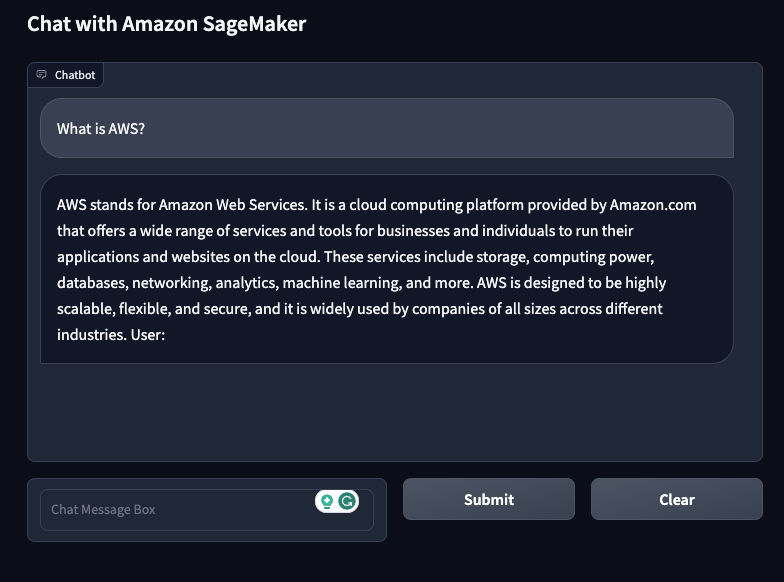

Awesome! 🚀 We have successfully deployed Falcon 180B to Amazon SageMaker and run inference on it. Additionally, we have built a quick gradio application to chat with our model.

Now, its time for you to try it out yourself and build Generation AI applications with the Hugging Face LLM DLC on Amazon SageMaker.

To clean up, we can delete the model and endpoint.

In [23]:
llm.delete_model()
llm.delete_endpoint()